In [1]:
# === Celda 1: Importaciones, rutas y estilo ===
from pathlib import Path
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Si ejecutas en nodo “headless” y NO quieres ver los gráficos en pantalla,
# descomenta estas 2 líneas:
# import matplotlib
# matplotlib.use("Agg")

# --- Rutas base (TUS datos de salida) ---
RUTA_BASE          = Path("/lustre/home/mvalenzuela/Ocotillo/DataAqua")
RUTA_SALIDA_UNISON = RUTA_BASE / "Salidas_ETo12" / "Periodo de Cultivo ETo"

# (solo por referencia futura; no la usamos en estas celdas)
RUTA_SALIDA_UAMEX  = RUTA_BASE / "Datos" / "ET Calculada - Por Periodo de Cultivo - 2010-2024"

# Estilo
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120


In [2]:
# === Celda 2: Normalización de columnas + parser de archivos ===

MAP_UNISON = {
    # mojibake y variantes
    "Año_ (YEAR)": "Year", "AÃ±o_ (YEAR)": "Year",
    "Día (DOY)": "DOY",   "DÃ­a (DOY)": "DOY",

    # base NASA renombrada en tu pipeline
    "Tmax (T2M_MAX)": "Tmax", "Tmin (T2M_MIN)": "Tmin",
    "HR (RH2M)": "HR", "Ux (WS2M)": "Ux",
    "Rs (ALLSKY_SFC_SW_DWN)": "Rs",
    "Rl_ (ALLSKY_SFC_LW_DWN)": "Rl",
    "Ptot_ (PRECTOTCORR)": "Ptot",

    # generadas / resultados
    "Pef_": "Pef", "Tmean_": "Tmean", "es_": "es", "ea_": "ea",
    "delta_": "delta", "P_": "P", "gamma_": "gamma",
    "Rns_": "Rns", "Rnl_": "Rnl", "Rn_": "Rn", "Rso_": "Rso",
    "Kc_": "Kc", "decada_": "decada",
    # finales
    "ET0": "ET0", "ETc": "ETc", "ETverde": "ETverde", "ETazul": "ETazul",
    # por si ya vienen así
    "Year": "Year", "DOY": "DOY", "Dia": "Dia"
}

# Parser: 'Cajeme-FAO56-2014-2015-SALIDA.csv' -> ('Cajeme','2014-2015')
def parse_unison_filename(filename: str):
    m = re.match(r"([A-Za-z]+)-FAO56-(\d{4})(?:-(\d{4}))?-SALIDA\.csv$", filename, re.I)
    if not m:
        return None, None
    reg, y1, y2 = m.groups()
    # normalizaciones comunes
    if reg == "VillaAllende": reg = "Villa de Allende"
    if reg == "Etchhojoa":    reg = "Etchojoa"
    ciclo = y1 if not y2 else f"{y1}-{y2}"
    return reg, ciclo


In [3]:
# === Celda 3: Catálogo de regiones y ciclos (a partir de archivos) ===

def catalogo_unison(base_dir: Path) -> pd.DataFrame:
    """
    Recorre RUTA_SALIDA_UNISON buscando archivos CSV con patrón:
      <Region>-FAO56-<YYYY>[-<YYYY>]-SALIDA.csv
    Devuelve un DataFrame con:
      - Region
      - Ciclo
      - Ruta  (Path absoluto al CSV)
    """
    registros = []
    for reg_folder in sorted(os.listdir(base_dir)):
        d = base_dir / reg_folder
        if not d.is_dir():
            continue
        for f in sorted(os.listdir(d)):
            if not f.lower().endswith(".csv"):
                continue
            reg, ciclo = parse_unison_filename(f)
            if reg and ciclo:
                registros.append({"Region": reg, "Ciclo": ciclo, "Ruta": str(d / f)})
    return pd.DataFrame(registros).sort_values(["Region","Ciclo"]).reset_index(drop=True)

# Genera el catálogo una vez:
CAT_UNISON = catalogo_unison(RUTA_SALIDA_UNISON)
display(CAT_UNISON.head(10))
print(f"Archivos detectados: {len(CAT_UNISON)}")


,Region,Ciclo,Ruta
0,Cajeme,2010-2011,/lustre/home/mvalenzuela/Ocotillo/DataAqua/Sal...
1,Cajeme,2011-2012,/lustre/home/mvalenzuela/Ocotillo/DataAqua/Sal...
2,Cajeme,2012-2013,/lustre/home/mvalenzuela/Ocotillo/DataAqua/Sal...
3,Cajeme,2013-2014,/lustre/home/mvalenzuela/Ocotillo/DataAqua/Sal...
4,Cajeme,2014-2015,/lustre/home/mvalenzuela/Ocotillo/DataAqua/Sal...
5,Cajeme,2015-2016,/lustre/home/mvalenzuela/Ocotillo/DataAqua/Sal...
6,Cajeme,2016-2017,/lustre/home/mvalenzuela/Ocotillo/DataAqua/Sal...
7,Cajeme,2017-2018,/lustre/home/mvalenzuela/Ocotillo/DataAqua/Sal...
8,Cajeme,2018-2019,/lustre/home/mvalenzuela/Ocotillo/DataAqua/Sal...
9,Cajeme,2019-2020,/lustre/home/mvalenzuela/Ocotillo/DataAqua/Sal...


Archivos detectados: 102


In [4]:
# === Celda 4: Lector robusto UNISON (respeta DOY/YEAR y deriva Fecha/Dia_ciclo) ===
from datetime import datetime, timedelta

COLUMNAS_MIN = ["Year","DOY","ET0","ETc","ETverde","ETazul","Pef","decada","Rns","Rnl","Rs","Tmean","HR","Ux","Kc"]

def leer_unison(path: Path) -> pd.DataFrame:
    # intenta utf-8 y luego latin-1
    last_err = None
    for enc in ("utf-8","latin-1"):
        try:
            df = pd.read_csv(path, encoding=enc)
            last_err = None
            break
        except UnicodeDecodeError as e:
            last_err = e
            continue
    if last_err is not None:
        df = pd.read_csv(path)

    # normaliza encabezados
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns=lambda c: MAP_UNISON.get(c, c))

    # tipos numéricos en columnas clave
    for c in set(COLUMNAS_MIN).intersection(df.columns):
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # === Construir calendario desde YEAR+DOY ===
    if {"Year","DOY"}.issubset(df.columns):
        def year_doy_to_date(y, doy):
            try:
                base = datetime(int(y), 1, 1)
                return base + timedelta(days=int(doy) - 1)
            except Exception:
                return pd.NaT
        fechas = [year_doy_to_date(y,d) for y,d in zip(df["Year"], df["DOY"])]
        df["Fecha"] = pd.to_datetime(fechas)

        # Dia_ciclo derivado del calendario (no inventado): días desde la 1a fecha
        if df["Fecha"].notna().any():
            f0 = df["Fecha"].dropna().iloc[0]
            df["Dia_ciclo"] = (df["Fecha"] - f0).dt.days.astype("Int64")
        else:
            df["Dia_ciclo"] = pd.Series(pd.NA, index=df.index, dtype="Int64")
    else:
        df["Fecha"] = pd.NaT
        df["Dia_ciclo"] = pd.Series(pd.NA, index=df.index, dtype="Int64")

    # Derivados para KPIs y gráficos
    if "ETc" in df:
        df["ETc_acum"] = df["ETc"].cumsum()
    if "ETazul" in df:
        df["ETazul_acum"] = df["ETazul"].cumsum()
    if {"ETc","ETazul"}.issubset(df.columns):
        df["pct_azul"] = np.where(df["ETc"]>0, df["ETazul"]/df["ETc"]*100.0, np.nan)

    return df


In [5]:
# === Celda 5: KPIs de ciclo ===
def kpis_ciclo(df: pd.DataFrame) -> pd.DataFrame:
    df0 = df.copy()
    mask = df0["ETc"].notna() if "ETc" in df0 else pd.Series(False, index=df0.index)
    dias = int(mask.sum())

    etc_total = float(df0.loc[mask, "ETc"].sum())     if "ETc"     in df0 else np.nan
    etv_total = float(df0.loc[mask, "ETverde"].sum()) if "ETverde" in df0 else np.nan
    eta_total = float(df0.loc[mask, "ETazul"].sum())  if "ETazul"  in df0 else np.nan
    pef_total = float(df0.loc[mask, "Pef"].sum())     if "Pef"     in df0 else np.nan

    pct_azul = (eta_total/etc_total*100.0) if (etc_total and etc_total>0) else np.nan
    dias_def = int(((df0["ETc"] > df0.get("Pef", 0)).fillna(False)).sum()) if "ETc" in df0 else np.nan
    pico_p95 = float(np.nanpercentile(df0["ETc"], 95)) if "ETc" in df0 else np.nan

    return pd.DataFrame([{
        "Días del ciclo": dias,
        "ETc total [mm]": round(etc_total,1),
        "ETverde total [mm]": round(etv_total,1),
        "ETazul total [mm]": round(eta_total,1),
        "%Azul [%]": round(pct_azul,1),
        "Pef total [mm]": round(pef_total,1),
        "Días con déficit (ETc>Pef)": dias_def,
        "Pico ETc p95 [mm/d]": round(pico_p95,2),
    }])


In [6]:
# === Celda 6: Funciones de gráficas (el dashboard y la libreta las llaman) ===

def _eje_x(df: pd.DataFrame, prefer="Fecha"):
    # devuelve el eje disponible (prioridad: Fecha > DOY > Dia_ciclo)
    if prefer in df.columns and df[prefer].notna().any():
        return prefer
    for alt in ("Fecha","DOY","Dia_ciclo"):
        if alt in df.columns and df[alt].notna().any():
            return alt
    return "index"

def fig_series(df: pd.DataFrame, region: str, ciclo: str, eje_prefer="Fecha"):
    xcol = _eje_x(df, eje_prefer)
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    for col, lab in [("ET0","ET0"),("ETc","ETc"),("ETverde","ETverde"),("ETazul","ETazul")]:
        if col in df:
            ax.plot(df[xcol], df[col], label=lab, lw=1.5)
    if "Pef" in df:
        ax.plot(df[xcol], df["Pef"], label="Pef", lw=1.2, alpha=0.7, color="tab:gray")
    ax.set_title(f"Serie diaria — {region} ({ciclo})")
    ax.set_xlabel(xcol); ax.set_ylabel("mm/día")
    ax.legend(); fig.tight_layout()
    return fig

def fig_acumulados(df: pd.DataFrame, region: str, ciclo: str, eje_prefer="Fecha"):
    xcol = _eje_x(df, eje_prefer)
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    if "ETc_acum" in df:
        ax.plot(df[xcol], df["ETc_acum"], label="ETc acumulado", lw=1.8)
    if "ETazul_acum" in df:
        ax.plot(df[xcol], df["ETazul_acum"], label="ETazul acumulado", lw=1.8)
    ax.set_title(f"Acumulados — {region} ({ciclo})")
    ax.set_xlabel(xcol); ax.set_ylabel("mm")
    ax.legend(); fig.tight_layout()
    return fig

def fig_decadico(df: pd.DataFrame, region: str, ciclo: str):
    if "decada" not in df: return None
    g = df.groupby("decada")[["ETc","ETazul"]].sum(min_count=1)
    fig, ax = plt.subplots(1,1, figsize=(10,4))
    g["ETc"].plot(kind="bar", ax=ax, color="#4C78A8", label="ETc")
    if "ETazul" in g:
        ax.plot(np.arange(len(g)), g["ETazul"].values, color="#F58518", lw=2, marker="o", label="ETazul")
    ax.set_title(f"Decádico — {region} ({ciclo})")
    ax.set_xlabel("Década del ciclo"); ax.set_ylabel("mm/decada")
    ax.legend(); fig.tight_layout()
    return fig

def fig_kc_et0(df: pd.DataFrame, region: str, ciclo: str, eje_prefer="Fecha"):
    if "Kc" not in df or "ET0" not in df: return None
    xcol = _eje_x(df, eje_prefer)
    fig, ax1 = plt.subplots(1,1, figsize=(12,4))
    ax1.plot(df[xcol], df["ET0"], color="#4C78A8", label="ET0", lw=1.5)
    ax1.set_ylabel("ET0 [mm/día]", color="#4C78A8"); ax1.tick_params(axis='y', labelcolor="#4C78A8")
    ax2 = ax1.twinx()
    ax2.plot(df[xcol], df["Kc"], color="#E45756", label="Kc", lw=1.5)
    ax2.set_ylabel("Kc [-]", color="#E45756"); ax2.tick_params(axis='y', labelcolor="#E45756")
    ax1.set_title(f"Kc y ET0 — {region} ({ciclo})"); ax1.set_xlabel(xcol)
    fig.tight_layout(); return fig

def fig_drivers_et0(df: pd.DataFrame, region: str, ciclo: str):
    drivers = [("Rs","Rs [MJ m$^{-2}$ d$^{-1}$]"),
               ("Rnl","Rnl [MJ m$^{-2}$ d$^{-1}$]"),
               ("HR","HR [%]"),
               ("Ux","Viento Ux [m/s]"),
               ("Tmean","Tmean [°C]")]
    cols = [c for c,_ in drivers if c in df.columns]
    if not cols or "ET0" not in df.columns: return None
    n = len(cols); ncols, nrows = 3, int(np.ceil(n/3))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows))
    axes = np.atleast_2d(axes).ravel()
    for i,(c,lab) in enumerate([d for d in drivers if d[0] in cols]):
        ax = axes[i]
        ax.scatter(df[c], df["ET0"], alpha=0.6, s=14)
        ax.set_xlabel(lab); ax.set_ylabel("ET0 [mm/día]")
        try:
            r = np.corrcoef(df[c].values, df["ET0"].values)[0,1]
            ax.set_title(f"ET0 vs {c}  (r={r:.2f})")
        except Exception:
            ax.set_title(f"ET0 vs {c}")
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    fig.tight_layout(); return fig


['Cajeme', 'Ensenada', 'Etchojoa', 'Metepec', 'Toluca', 'Villa de Allende', 'Zapopan']


,Year,DOY,Tmax,Tmin,HR,Ux,Rs,Rl,Ptot,Pef,...,decada,ET0,ETc,ETverde,ETazul,Fecha,Dia_ciclo,ETc_acum,ETazul_acum,pct_azul
0,2014,303,32.21,19.95,57.60,1.76,17.95,30.87,0.00,0.000,...,1,4.571548,1.371464,0.000000,1.371464,2014-10-30,0,1.371464,1.371464,100.000000
1,2014,304,31.32,21.63,57.10,2.05,16.55,31.04,0.00,0.000,...,1,4.584128,1.375238,0.000000,1.375238,2014-10-31,1,2.746703,2.746703,100.000000
2,2014,305,31.79,21.35,54.51,1.87,12.55,32.43,0.00,0.000,...,1,4.066943,1.220083,0.000000,1.220083,2014-11-01,2,3.966786,3.966786,100.000000
3,2014,306,30.35,22.43,61.93,2.07,10.09,34.36,7.17,5.736,...,1,3.534540,1.060362,1.060362,0.000000,2014-11-02,3,5.027148,3.966786,0.000000
4,2014,307,26.23,17.63,57.48,2.96,10.29,32.64,0.97,0.776,...,1,3.849576,1.154873,0.776000,0.378873,2014-11-03,4,6.182021,4.345659,32.806457


,Días del ciclo,ETc total [mm],ETverde total [mm],ETazul total [mm],%Azul [%],Pef total [mm],Días con déficit (ETc>Pef),Pico ETc p95 [mm/d]
0,172,639.2,29.9,609.2,95.3,93.1,162,6.52


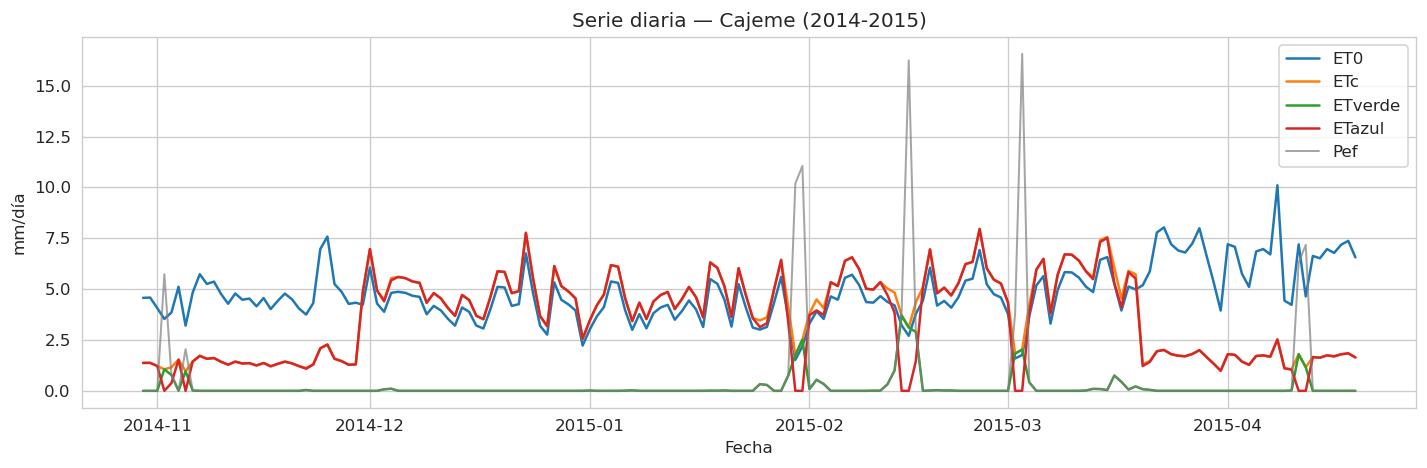

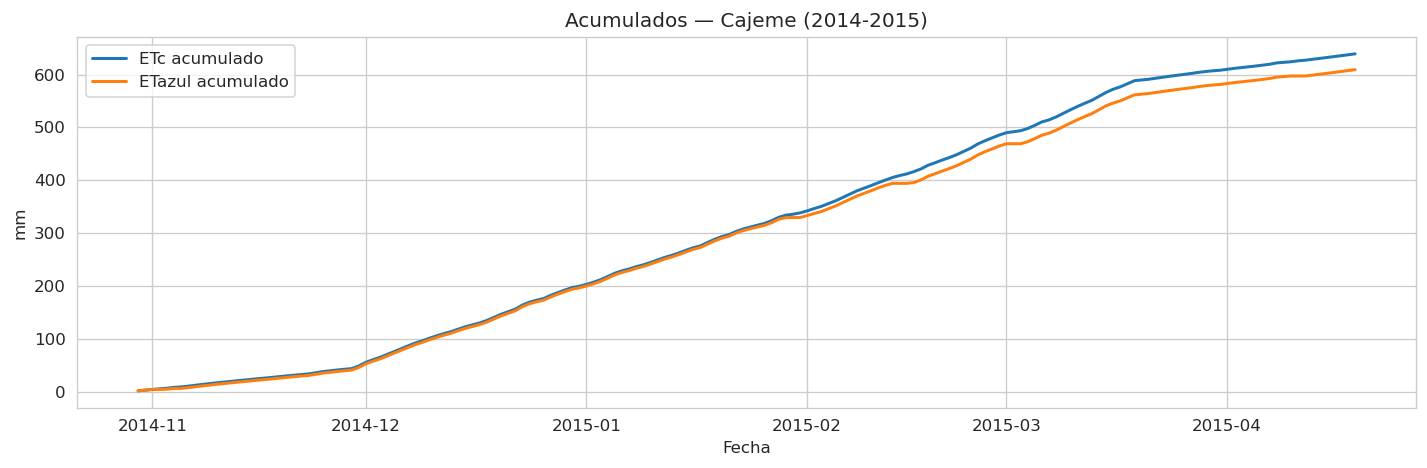

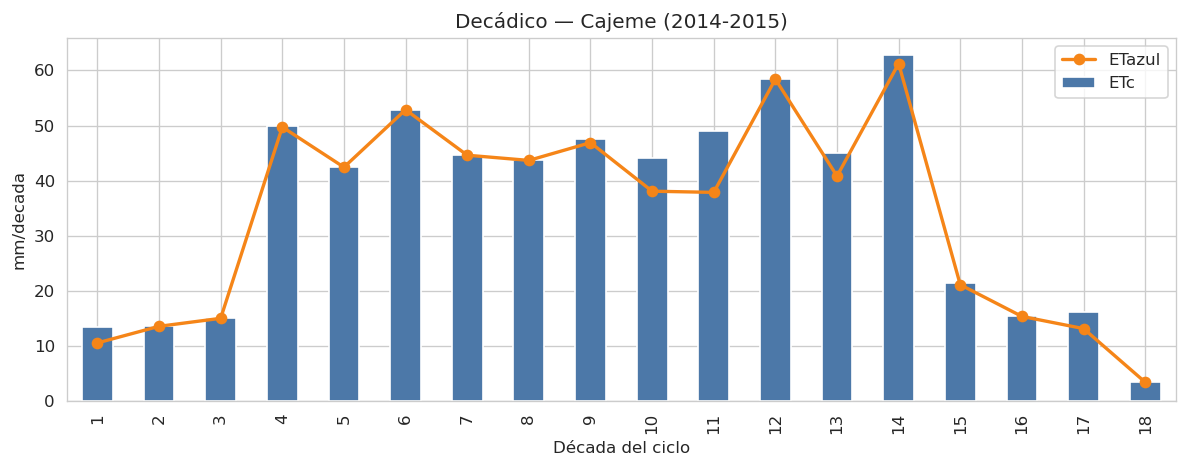

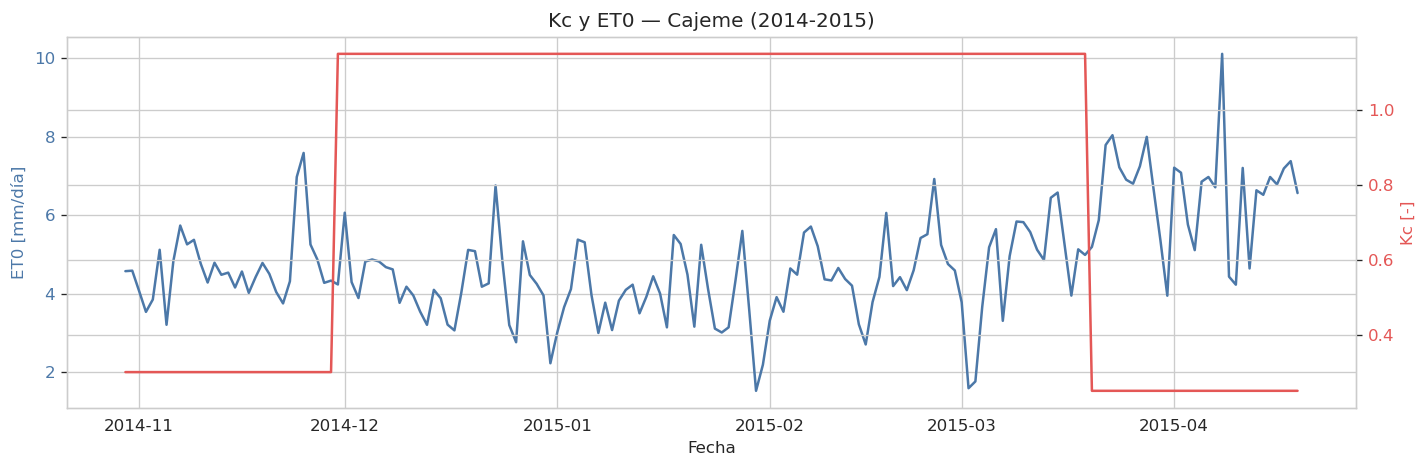

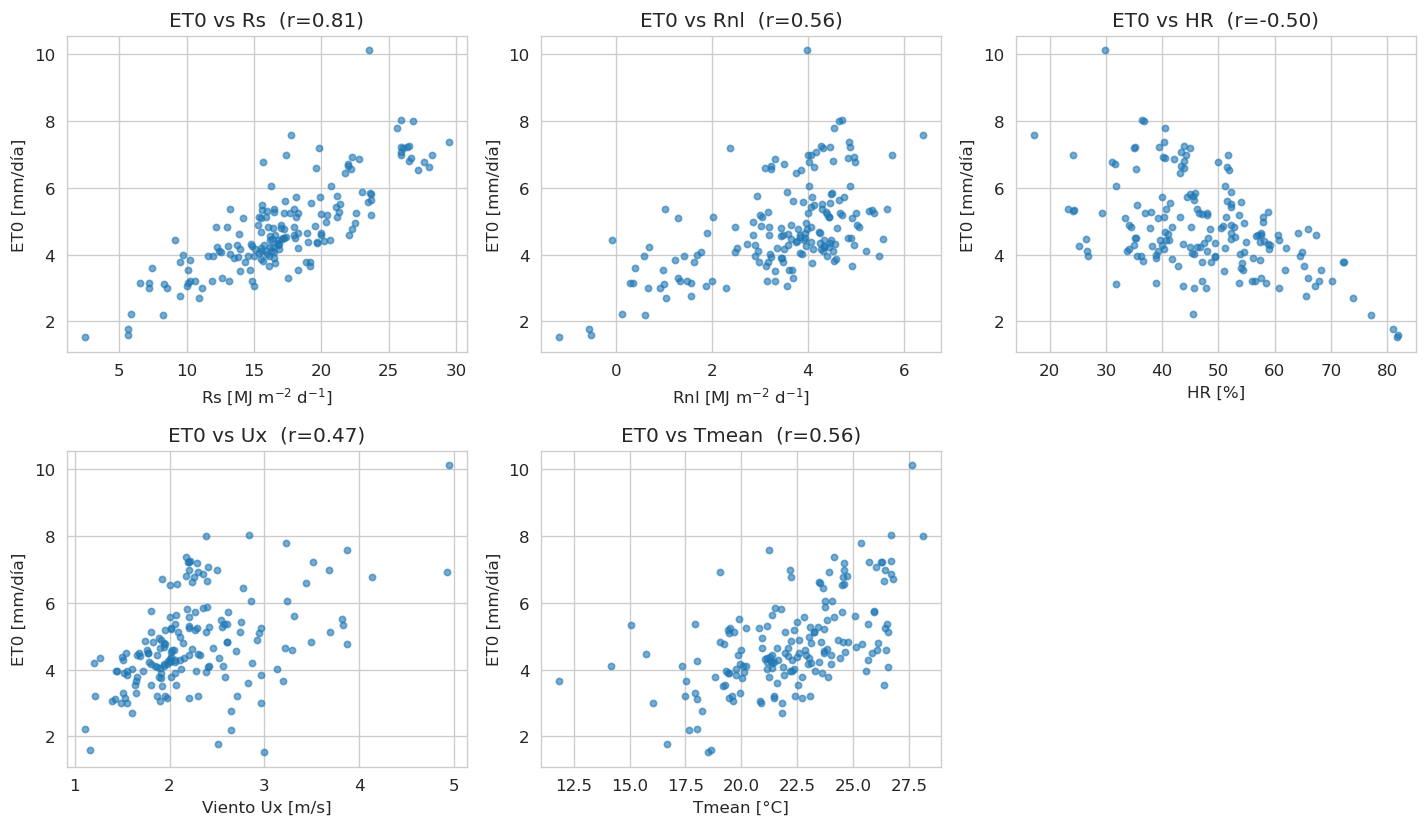

In [7]:
# === Celda 7: Ejecutar para una selección concreta (vista rápida en Jupyter) ===

# 1) Elige región y ciclo de lo que detectó el catálogo:
print(sorted(CAT_UNISON["Region"].unique()))
REGION_SEL = "Cajeme"        # <-- cambia aquí
CICLO_SEL  = "2014-2015"     # <-- cambia aquí (usa un ciclo que exista para esa región)

# 2) Ubica la ruta y carga
ruta_sel = CAT_UNISON[(CAT_UNISON.Region==REGION_SEL) & (CAT_UNISON.Ciclo==CICLO_SEL)]["Ruta"]
if ruta_sel.empty:
    raise ValueError(f"No encontré el CSV para {REGION_SEL} / {CICLO_SEL}")
ruta_sel = Path(ruta_sel.iloc[0])

df = leer_unison(ruta_sel)
display(df.head())

# 3) KPIs
display(kpis_ciclo(df))

# 4) Gráficas (se muestran en notebook)
fig = fig_series(df, REGION_SEL, CICLO_SEL, eje_prefer="Fecha"); 
plt.show(fig)

fig = fig_acumulados(df, REGION_SEL, CICLO_SEL, eje_prefer="Fecha"); 
plt.show(fig)

fdec = fig_decadico(df, REGION_SEL, CICLO_SEL)
if fdec is not None: plt.show(fdec)

fkc = fig_kc_et0(df, REGION_SEL, CICLO_SEL, eje_prefer="Fecha")
if fkc is not None: plt.show(fkc)

fdrv = fig_drivers_et0(df, REGION_SEL, CICLO_SEL)
if fdrv is not None: plt.show(fdrv)
